In [47]:
import numpy as np
from pynverse import inversefunc
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import warnings
warnings.simplefilter("ignore")

from myopacus.accountants.analysis import rdp as privacy_analysis

# noise_multiplier = 10.0
# steps = 100
# rounds = 50
# target_delta = 1e-4
# client_rates = [0.8, 0.5, 0.2]

noise_multiplier = 10.0
steps = 100
rounds = 50
target_delta = 1e-4
client_rates = [0.7, 0.6, 0.2]

# Fit functions
fit_func = {
    "linear1":(lambda x, m, b: m * x + b, lambda m, b: f"{m:.2f}q + {b:.2f}"),  # y = mx + b
    "linear2":(lambda x, m, b, c: m * x + b + c, lambda m, b, c: f"{m:.2f}q + {b:.2f} + {c:.2f}"),  # y = mx + b + c
    "linear3":(lambda x, m, b, c: m * x**2 + b * x + c, lambda m, b, c: f"{m:.2f}q^2 + {b:.2f}q + {c:.2f}"),  # quadratic linear function
    "linear4":(lambda x, m, b, c, d: m * x**3 + b * x**2 + c * x + d, lambda m, b, c, d: f"{m:.2f}q^3 + {b:.2f}q^2 + {c:.2f}q + {d:.2f}"),  # y = mx^3 + bx^2 + cx + d
    #"linear5":(lambda x, m, b, c, d, e: m * np.log(x + 1) + b * x + c, lambda m, b, c, d, e: f"{m:.2f}log(q+1) + {b:.2f}q + {c:.2f}")  # log-linear model
    #"linear5":(lambda x, m, b, c, d: m * np.log(x + 1) + b * x**2 + c * x + d, lambda m, b, c, d: f"{m:.2f}log(q+1) + {b:.2f}q^2 + {c:.2f}q + {d:.2f}"),  # y = m*log(q+1) + b*q^2 + c*q + d 
    "linear5":(lambda x, m, b, c, d, e: m * x**4 + b * x**3 + c * x**2 + d * x + e, 
                lambda m, b, c, d, e: f"{m:.2f}q^4 + {b:.2f}q^3 + {c:.2f}q^2 + {d:.2f}q + {e:.2f}"),  # y = mq^4 + bq^3 + cq^2 + dq + e
}

# pre-defined rdp order list
orders = privacy_analysis.generate_rdp_orders()

# pre-defined sampling rates
q_examples = [0.001, 0.01, 0.1, 0.5, 0.9, 1.0]

q_candidates = np.concatenate([np.arange(0, 1.0, 0.01), np.arange(0, 0.1, 0.001), [1.0]])
q_candidates = np.array(sorted(np.unique(q_candidates)), dtype=np.float32)
q_candidates = q_candidates[q_candidates > 1e-5] # remove all candidates that less than 1e-5

In [48]:
all_examples = []
for _, client_q in enumerate(client_rates):
    examples = []
    for q in q_candidates:
        total_rdp = privacy_analysis.compute_rdp_fed(
            q=q, client_q=client_q,
            noise_multiplier=noise_multiplier,
            steps=steps, 
            rounds=rounds,
            orders=orders
        )
        eps, _ = privacy_analysis.get_privacy_spent(
            orders=orders, rdp=total_rdp, delta=target_delta)
        examples.append(eps)
    all_examples.append(np.array(examples, dtype=np.float32))

In [49]:
all_popts, all_r2 = [], []
keys = ["linear1", "linear2", "linear3", "linear4", "linear5"]

for i, client_q in enumerate(client_rates):
    popts_dict = dict(zip(keys, [0]*len(keys)))
    r2_dict = dict(zip(keys, [0]*len(keys)))
    for key, (func, func_str) in fit_func.items():
        popt, _ = curve_fit(func, q_candidates, all_examples[i])
        r2 = r2_score(func(q_candidates, *popt), all_examples[i])
        popts_dict[key] = popt
        r2_dict[key] = r2
        print(f'The R-Squared value of the best-fit curve {func_str(*popt)} for client_rate = {client_q}:', r2)
    all_popts.append(popts_dict)
    all_r2.append(r2_dict)

The R-Squared value of the best-fit curve 23.39q + -0.76 for client_rate = 0.7: 0.9921372963798585
The R-Squared value of the best-fit curve 23.39q + -104.77 + 104.02 for client_rate = 0.7: 0.9921372931099826
The R-Squared value of the best-fit curve 8.91q^2 + 15.74q + -0.14 for client_rate = 0.7: 0.9995994090511368
The R-Squared value of the best-fit curve -6.28q^3 + 17.77q^2 + 12.66q + 0.00 for client_rate = 0.7: 0.9998187769500648
The R-Squared value of the best-fit curve -3.00q^4 + -0.56q^3 + 14.37q^2 + 13.30q + -0.02 for client_rate = 0.7: 0.9998222830263691
The R-Squared value of the best-fit curve 21.53q + -0.69 for client_rate = 0.6: 0.992158384748757
The R-Squared value of the best-fit curve 21.53q + -104.74 + 104.05 for client_rate = 0.6: 0.992158389186978
The R-Squared value of the best-fit curve 8.14q^2 + 14.54q + -0.13 for client_rate = 0.6: 0.9995071935325441
The R-Squared value of the best-fit curve -6.43q^3 + 17.21q^2 + 11.38q + 0.02 for client_rate = 0.6: 0.99977896780

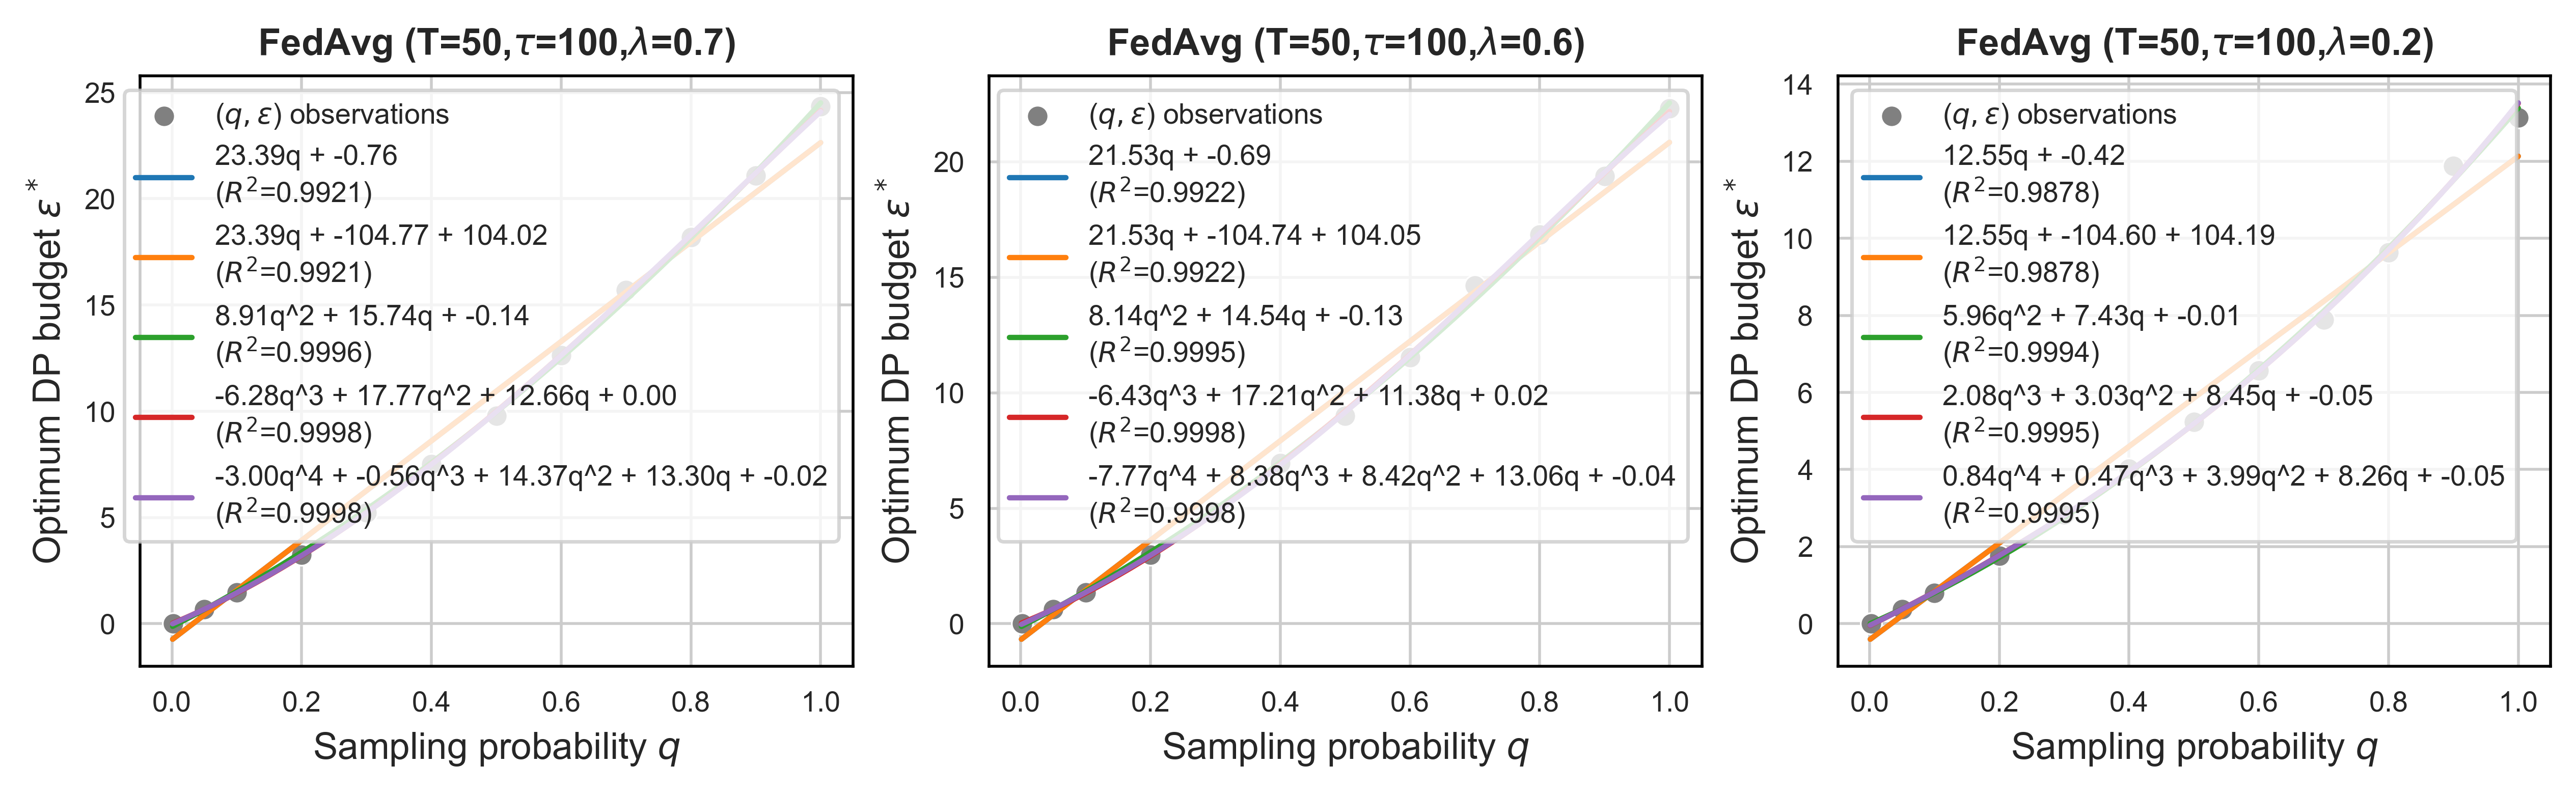

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

legend_font = {'style': 'normal', 'size': 8, 'weight': "normal"}
label_font = {'family':'sans-serif', 'size': 10.5, 'weight': "normal"}
title_font = {'family':'sans-serif', 'size': 10.5, 'weight': "bold"}

# Here we just demo a subset of points (observations) for a more clear illustration
idx = [1, 49, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189] 

plt.close('all')
fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True, dpi=500)
r"""Comparison between different linear functions."""
for (client_q, examples, popts_dict, r2_dict, ax) in zip(client_rates, all_examples, all_popts, all_r2, axs):
    sns.scatterplot(x=q_candidates[idx], y=examples[idx], label=r'($q,\varepsilon$) observations', color='grey', ax=ax) 
    for key, (func, func_str) in fit_func.items():
        sns.lineplot(x=q_candidates, y=func(q_candidates, *popts_dict[key]), 
                     label=func_str(*popts_dict[key])+f"\n($R^2$={r2_dict[key]:5.4f})", 
                     linestyle='-', ax=ax)

    ax.legend(prop=legend_font)
    ax.set_ylabel(r'Optimum DP budget $\varepsilon^*$', **label_font)
    ax.set_xlabel('Sampling probability $q$', **label_font)
    ax.tick_params(labelsize=8)
    ax.set_title(f'FedAvg (T={rounds},$\\tau$={steps},$\\lambda$={client_q})', **title_font)

plt.show()

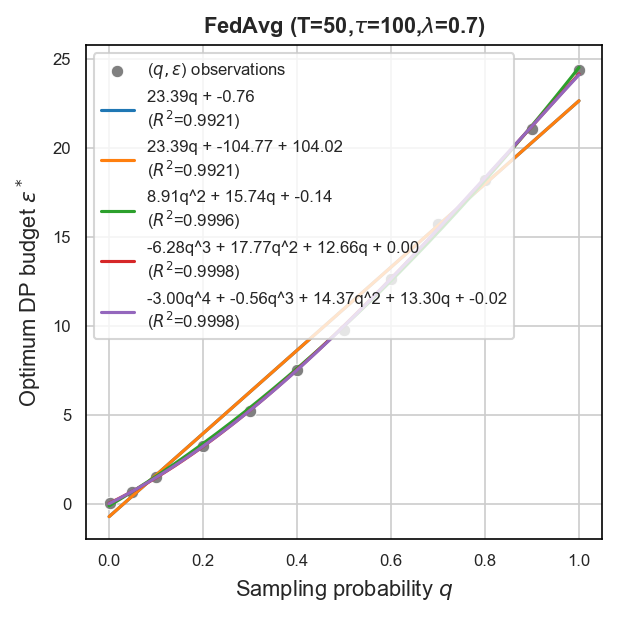

In [51]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True, dpi=150)
r"""Comparison between different linear functions."""
selected_id = 0
sns.scatterplot(x=q_candidates[idx], y=all_examples[selected_id][idx], label=r'($q,\varepsilon$) observations', color='grey', ax=ax) 
for key, (func, func_str) in fit_func.items():
    sns.lineplot(x=q_candidates, y=func(q_candidates, *all_popts[selected_id][key]), 
                 label=func_str(*all_popts[selected_id][key])+f"\n($R^2$={all_r2[selected_id][key]:5.4f})", 
                 linestyle='-', ax=ax)

ax.legend(prop=legend_font)
ax.set_ylabel(r'Optimum DP budget $\varepsilon^*$', **label_font)
ax.set_xlabel(r'Sampling probability $q$', **label_font)
ax.tick_params(labelsize=8)
ax.set_title(f'FedAvg (T={rounds},$\\tau$={steps},$\\lambda$={client_rates[selected_id]})', **title_font) 

plt.show()